In [95]:
import numpy as np
import random
import tensorflow as tf
import os
import csv
# import keras

#Env

In [96]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import os

class Helper:
    def __init__(self, rc, max_f, max_c):
        """
        Initial Method for Continuous Environment
        params - rc: float - Radius Cycle
        params - max_f: float - Maximum CPUs
        params - max_c: float - Maximum Costs
        """
        if rc < 0 or max_f < 0 or max_c < 0:
            raise Exception(
                    "Initial Values for Helper must be Positive!"
                )
        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c

        self.f = None
        self.c = None

    def become_stranger(self):
        """This node become to a Stranger Node"""
        f_frac = np.random.uniform(low=1e-6, high=1e-5)
        c_frac = np.random.uniform(low=0.08, high=0.01)
        self.f = self.f * f_frac
        self.c = self.c * c_frac

        if np.random.rand() < 0.9:
            self.c = self.c  * f_frac * np.random.uniform(low=10.0, high=20.0)
        else:
            self.c = self.c * f_frac

    def reset(self):
        """
        Create a New Instance
        """
        self.f = np.random.normal(loc=self.max_f * 0.5, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.max_c * 0.5, scale=self.max_c * 1e-4)

        # if np.random.rand() < 0.1:
        #     self.become_stranger()

        if self.f < 0:
            self.f = self.max_f * 0.5
        if self.c < 0:
            self.c = self.max_c * 0.5

    def transit(self):
        """
        Move to a Next State
        """
        self.f = np.random.normal(loc=self.f, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.c, scale=self.max_c * 1e-4)

        if self.f < 0:
            self.f = self.max_f * 0.5

        if self.c < 0:
            self.c = self.max_c * 0.5

        if np.random.rand() < 0.1:
            self.become_stranger()

    def cal_com_latency(self, num_bytes):
        """
        Calculate The Latency for Computing "num_bytes" data 
        params: num_bytes - Integer - Computation Demand
        """
        num_bytes = float(num_bytes)
        latency = num_bytes / self.f
        return latency

    def cal_offload_latency(self, num_bytes, mu, m, d_n):
        """
        Calculate The Latency for Offloading "num_bytes" data
        params: num_bytes - Integer - Offloading Demand
        """
        num_bytes = float(num_bytes)
        # Transformation Parameters
        CO = 3*1e8
        Fc = 1e4
        BW = 10e7
        G_RA = 1.8
        P_max = 200*10**(-3)
        Loss_free = (4*np.pi* Fc * d_n/CO)**2
        sigma_2 = 4*10**(-21)

        pr = (mu*P_max*(G_RA)**2)/Loss_free
        SNR = m*pr/(BW*sigma_2)
        rn = (BW/m) * np.log2(1.0 + SNR) 
        latency = num_bytes / rn
        return latency

    def cal_incentive_cost(self, num_bytes):
        """
        Calculate the Incentive Cost for Processing "num_bytes" data
        params: - num_bytes : Integer
        """
        cost = self.c * self.cal_com_latency(num_bytes)
        return cost

    def show_cur_state(self):
        print("d: {:.3f}, f: {:.3f}, c: {:.10f}".format(self.d, self.f, self.c))

    def get_state(self):
        """
        Get the Current State of This Helper
        """
        state = [self.f/self.max_f, self.c/self.max_c]

        return state

class TaskOffloadEnv:
    def __init__(self, n_helpers, rc, max_f, max_c, max_l, alpha1, alpha2, alpha3, alpha4, v_min, v_max,  seed):
        """
        Initial Method for Task Offload Environments
        """
        self.n_helpers = n_helpers

        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c
        self.max_l = max_l

        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.alpha3 = alpha3
        self.alpha4 = alpha4
        self.helpers = {}
        self.step_counter = 0

        self.v_min = v_min
        self.v_max = v_max

        self.curr_n_helpers = self.n_helpers

        # environment's configuration
        self.act_dims = [self.n_helpers] + [2 for _ in range(self.n_helpers)] + [2] 
        self.num_actions = self.n_helpers * (2 ** self.n_helpers) * 2
        self.env_dims = 2 + self.n_helpers * 6

        # Client initialization
        self.x_0 = 0
        self.y_0 = 0
        self.v_x = 0
        self.v_y = 0

        self.userList_x = []
        self.userList_y = []
        self.userList_location = []
        
        self.userList_velocity_x = []
        self.userList_velocity_y = []
        self.userList_velocity = []

        self.d_n = 0

        np.random.seed(seed)

    def _clientInit(self, ):
      for user_no in range(self.n_helpers):
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x1 = self.x_0 + user_Radius * math.cos(user_Angle)
        user_x2 = self.x_0 - user_Radius * math.cos(user_Angle)
        user_x = random.choice([user_x1, user_x2])
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        self.userList_x.append(user_x)
        self.userList_y.append(user_y)
        self.userList_location.append([user_x, user_y])
        self.userList_velocity.append([user_vx, user_vy])

      # # Client Plot
      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # print(f"List of user location is: {self.userList_location}")
      # print(f"List of user velocity is: {self.userList_velocity}")
      # plt.scatter(self.userList_x, self.userList_y)
      # plt.show()
    
    def distance(self):
      userList_distance = []            
      # init client location:               
      client_location = (self.x_0, self.y_0)
      for user_no in range(self.n_helpers):
        #print(f"user_no {user_no}")
        user_distance = np.linalg.norm(np.array(self.userList_location[user_no]) - np.array(client_location))
        userList_distance.append(user_distance)
      #print(f"List of user distance is: {userList_distance}")
      return userList_distance

    def get_state(self):
        """
        Get Environment State
        """
        
        client_state = [self.l*1.0/self.max_l]
        helper_state = []
        userList_distance = self.distance()
        num_helpers = 0
        for key in sorted(list(self.helpers.keys())):                    
          if userList_distance[key] > self.rc:
            state_f_c = [0,0]
          else:
            helper = self.helpers[key]
            state_f_c = helper.get_state()
            num_helpers = num_helpers + 1
          location = self.userList_location[key]
          x = location[0]/self.rc
          y = location[1]/self.rc
          position = [x,y]
          velocity = self.userList_velocity[key]
          v_x = velocity[0]/self.v_max
          v_y = velocity[1]/self.v_max
          v= [v_x, v_y]
          state = position + v + state_f_c
          helper_state += state
          
        env_state = [num_helpers] + client_state + helper_state
        #print(f"env_state : {env_state}")
        return env_state

    def reset(self):
        """
        Create a New Instance
        """
        self._clientInit()
        self.l = np.random.normal(loc=self.max_l * 0.5, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5
        self.step_counter = 0
        for idx in range(self.n_helpers):
            self.helpers[idx] = Helper(self.rc, self.max_f, self.max_c)
            self.helpers[idx].reset()            
        self.client_f = self.max_f * np.random.normal(loc=0.0001, scale= 1e-6)

        state = self.get_state()
        #print(f"List of user state is: {state}")
        return state

    def Markov_chain(self,num_n_vehicles):

      n_vehicle_state = {0 : "N1",1 : "N2",2 : "N3", 3 : "N4", 4 : "N5"}
      State_1 = [0.4, 0.5, 0.05, 0.05, 0]
      State_2 = [0.3, 0.2, 0.3, 0.1, 0.1]
      State_3 = [0, 0.3, 0.3, 0.4, 0]
      State_4 = [0.05, 0.05, 0.3, 0.3, 0.3]
      State_5 = [0, 0.1, 0.2, 0.3, 0.4]
      transitionMatrix = np.array([State_1, State_2, State_3, State_4, State_5])
      activityList = []
      start_n_vehicles = num_n_vehicles - 1 
      next_n_vehicles = np.random.choice([0,1,2,3,4], p = transitionMatrix[start_n_vehicles])
      return next_n_vehicles + 1

    def transmit(self, curr_n_vehicles):
      # x = x + v_x*t, y = y + v_y*t
      y_vecto = []
      over_n_vehicles = 0
      index = []
      for user_no in range(self.n_helpers):
        self.userList_location[user_no][0] = self.userList_location[user_no][0] + self.userList_velocity[user_no][0]
        self.userList_location[user_no][1] = self.userList_location[user_no][1] + self.userList_velocity[user_no][1]

      userList_distance = self.distance()
      for user_no in range(self.n_helpers):
        if userList_distance[user_no] > self.rc:
          over_n_vehicles += 1
          index.append(user_no)
      remain_n_vehicles = curr_n_vehicles - over_n_vehicles

      next_n_vehicles = self.Markov_chain(remain_n_vehicles)

      if next_n_vehicles > remain_n_vehicles:
        add_num = next_n_vehicles - remain_n_vehicles
        #print(f"add_num: {add_num}")
        for i in range(add_num):
            idx = index[i]
            self.userList_location[idx], self.userList_velocity[idx] = self.out_of_range(add_num) 
        curr_n_vehicles = next_n_vehicles

      else:
        curr_n_vehicles = remain_n_vehicles     
      #print(f"curr_n_vehicles is: {curr_n_vehicles}")
      for key in self.helpers.keys():
        self.helpers[key].transit()

      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # userList_x,userList_y = [],[]
      # for user_no in range(self.n_helpers):
      #   x = self.userList_location[user_no][0]
      #   y= self.userList_location[user_no][1]
      #   userList_x.append(x)
      #   userList_y.append(y)
      # plt.scatter(userList_x, userList_y)
      # plt.show()
    
    def out_of_range(self, num):
      # When vehicles go through the circle
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x = self.x_0 - user_Radius * math.cos(user_Angle)
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        location = [user_x, user_y]
        velocity = [user_vx, user_vy]
        return location, velocity


    def step(self, action):
        """
        Perform an action
        action's format [k, a1, ..., aN, B_c]

        """
        done = False
        c0 = 3*10**8
        P_max = 200*10**(-3)
        G_RA = 1.8
        sigma_c = 100
        P_ra_min = 10**(-13)
        Lambda = 0.1
        f_rad = 76*10**9

        k = action[0]
        if action[-1] == 1:
          Power = 0.7
        else:
          Power = 0.9
        mu = Power
        a_vec = action[-self.n_helpers-1:-1]
        m = sum(a_vec)
        standard_time = self.l / self.client_f      
        com_fee, total_latency, required_connect = [], [], []
        num_bytes = self.l / k
        userList_distance = self.distance()
        for idx in sorted(list(self.helpers.keys())):
            if a_vec[idx] == 0:
                total_latency.append(np.Inf)
                com_fee.append(0.0)
                required_connect.append(0.0)
            else:
                helper = self.helpers[idx]
                d_n = userList_distance[idx]
                offload_latency = helper.cal_offload_latency(num_bytes, mu, m, d_n)
                com_latency = helper.cal_com_latency(num_bytes)
                fee = helper.cal_incentive_cost(num_bytes)
                com_fee.append(fee)
                total_n = offload_latency + com_latency
                total_latency.append(total_n)
                duration = self.constrain(self.rc, self.userList_velocity[idx][0], 0 , d_n, 0)
                if total_n <= duration:
                  rw_link =  Lambda
                else:
                  rw_link = 0
                required_connect.append(rw_link)

        total_latency = sorted(total_latency)
        required_latency = max(total_latency[:k])
        required_fee = np.sum(com_fee)
        connect_rw = np.sum(required_connect)
        lamda_rad = c0/f_rad
        res_max = (P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        res = ((1-mu)*P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        rw_anten =  res/res_max
        required_anten =  rw_anten
        done = False
        # Calculate in Case the action meets the conditions
        if k <= m:
            if required_latency > standard_time:
                com_reward = -standard_time
            else:
                com_reward = standard_time - required_latency
            com_reward = com_reward * self.alpha1
            cost_reward = required_fee * self.alpha2
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        else:
            """
            an action doesn't meet the conditions
            """
            com_reward = -1.0 * self.alpha1 * standard_time
            cost_reward = 1.0 * self.alpha2 * required_fee
            if m == 0:
                cost_reward = (self.l / self.client_f) * self.max_c
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        reward = [total_reward, com_reward, cost_reward, anten_reward, connect_reward]
        
        """
        Move to the next State
        """
        self.l = np.random.normal(loc=self.l, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5

        self. transmit(self.curr_n_helpers)
        next_state = self.get_state()
        return next_state, reward, done

    def sam_action(self):
        """
        select one action randomly
        action's format [k, a1, ..., aN]
        """
        k = random.randint(1, self.n_helpers)
        n = random.randint(1, self.n_helpers)
        mylist = [0.7, 0.9]
        Power = []
        for i in range(len(mylist)):
          if mylist[i]==0.7:
            pw = 1
          else:
            pw = 2
          Power.append(pw)

        mu = random.choice(Power)
        a_vec = [0.0 for _ in range(self.n_helpers)]
        sel_helper_idxs = np.random.permutation(self.n_helpers)[0:n]
        for helper_idx in list(sel_helper_idxs):
            a_vec[helper_idx] = 1.0
        action = [k] + a_vec + [mu]
        return action

    def constrain(self, D, v_n, v_t, z_n, z_t):
      duration = D/(v_n-v_t) - (z_n - z_t)/(v_n-v_t)
      return duration

    def action2index(self, action):
        """
        Convert action from nulti-dimension format to index format
        """
        if len(action) != len(self.act_dims):
            raise Exception("Shape Error")
        
        act_idx = action[0] - 1
        for i in range(1, len(self.act_dims)-1):
            act_idx = act_idx * self.act_dims[i] + action[i]
        act_idx = act_idx * 2 + (action[-1] - 1)
        return act_idx

    def index2action(self, act_idx):
        """
        Convert action from index format to multi-dimension format
        """
        action = []
        action_bw = act_idx % 2
        act_idx = (act_idx - action_bw)/2
        #action_bw = action_bw + 1
        for i in range(len(self.act_dims)-1, 1, -1):
            ai = act_idx % self.act_dims[i-1]
            action.append(int(ai))
            act_idx = (act_idx - ai) / self.act_dims[i-1]
        
        action.append(int(act_idx))
        action = [action_bw+ 1] + action
        action.reverse()
        action[0] = action[0] + 1
        return action

    def Greedy_action(self,state):
      mu = 2 #(mu = 0.9)
      k = state[0]
      index_list_vehicle = [1.0 for _ in range(self.n_helpers)]
      action = [k] + index_list_vehicle + [mu]
      return action      


if __name__ == "__main__":
    env = TaskOffloadEnv(n_helpers=5,rc=100,max_f=100,max_c=100,max_l=100,alpha1=1.0,alpha2=1.0,alpha3=1.0,alpha4=1.0, v_min=0,v_max=50,seed=1)
    action = env.sam_action()
    idx = env.action2index(action)
    recovered = env.index2action(idx)
    print(idx)
    print(action, recovered)


72.0
[2, 0.0, 0.0, 1.0, 0.0, 0.0, 1] [2, 0, 0, 1, 0, 0, 1.0]


#Parameters

In [97]:
n_helpers = 5
rc = 100.0
max_f = 2e9
max_c = 1
max_l = 3e5*80
alpha1 = 5.0
alpha2 = 2.0
alpha3 = 5.0
alpha4 = 5.0
BW = 10e7
seed = 1
v_min = 0
v_max = 10
num_episodes = 70
max_step_per_episode = 500
buffer_size = 2000
batch_size = 32
max_eps = 1.0
epsilon = max_eps
min_eps = 0.1
gpu_idx = -1
log_dir = "../log"

CHECKPOINT = 20

# Main

In [98]:
gamma = 0.99
env = TaskOffloadEnv(n_helpers,rc,max_f,max_c,max_l,alpha1,alpha2,alpha3, alpha4, v_min, v_max, seed)
# state = env.reset()
log_total_reward_greedy, log_comp_reward_greedy, log_cost_reward_greedy, log_anten_reward_greedy, log_connect_reward_greedy = [], [], [], [], []
frame_count = 0
epsilon = max_eps
for episode in range(num_episodes):
	state = env.reset()
	for step in range(max_step_per_episode):
		action = env.Greedy_action(state)
		next_state, reward, done = env.step(action)
		state = next_state		
		''' 
			Average & Print
		'''
		if ((step) % CHECKPOINT >= 0) and ((step) % CHECKPOINT <= CHECKPOINT - 1):
			if (step) % CHECKPOINT == 0:
				list_total_greedy, list_comp_greedy, list_cost_greedy, list_anten_greedy, avg_connect_greedy, list_connect_greedy = [], [], [], [], [], []

				total_reward_greedy, comp_reward_greedy, cost_reward_greedy, anten_reward_greedy, connect_reward_greedy = 0, 0, 0, 0, 0
				total_greedy = 0	
	
			total_reward_greedy = reward[0]
			comp_reward_greedy = reward[1]
			cost_reward_greedy = reward[2] 
			anten_reward_greedy = reward[3]
			connect_reward_greedy = reward[4]
			list_total_greedy.append(total_reward_greedy)
			list_comp_greedy.append(comp_reward_greedy)
			list_cost_greedy.append(cost_reward_greedy)
			list_anten_greedy.append(anten_reward_greedy)
			list_connect_greedy.append(connect_reward_greedy)

			if (step) % CHECKPOINT == CHECKPOINT - 1:		
				avg_total_greedy = np.mean(list_total_greedy)
				avg_comp_greedy = np.mean(list_comp_greedy)
				avg_anten_greedy = np.mean(list_anten_greedy)
				avg_cost_greedy = np.mean(list_cost_greedy)
				avg_connect_greedy = np.mean(list_connect_greedy)
					
				log_total_reward_greedy.append(avg_total_greedy)
				log_comp_reward_greedy.append(avg_comp_greedy)
				log_cost_reward_greedy.append(avg_cost_greedy)
				log_anten_reward_greedy.append(avg_anten_greedy)
				log_connect_reward_greedy.append(avg_connect_greedy)
			if (step) % CHECKPOINT == CHECKPOINT - 1:
				print("EP {} - Step {} || Total {:.5f} - Comp {:.5f} - Cost {} - Anten {} - Connect {}".\
					format(episode, step, avg_total_greedy, avg_comp_greedy, avg_cost_greedy, avg_anten_greedy, avg_connect_greedy))
		if step == max_step_per_episode - 1:
			print(done)
			done = True
		if reward[0] >= 4000:  # Condition to consider the task solved
			print("Break at step {}!".format(step))
			done = True
			break

EP 0 - Step 19 || Total 96.04407 - Comp 95.54790 - Cost 4.065536269266208 - Anten 2.811706625951745 - Connect 1.75
EP 0 - Step 39 || Total -51.49252 - Comp 139.07597 - Cost 194.93020406046995 - Anten 2.811706625951745 - Connect 1.55
EP 0 - Step 59 || Total 56.86098 - Comp 55.90947 - Cost 3.910196725384618 - Anten 2.811706625951745 - Connect 2.05
EP 0 - Step 79 || Total 98.65836 - Comp 116.40254 - Cost 22.055879207023963 - Anten 2.811706625951745 - Connect 1.5
EP 0 - Step 99 || Total 147.46398 - Comp 148.77628 - Cost 6.3740035296143125 - Anten 2.811706625951745 - Connect 2.25
EP 0 - Step 119 || Total 54.55750 - Comp 65.00846 - Cost 15.437662536921502 - Anten 2.811706625951745 - Connect 2.175
EP 0 - Step 139 || Total 26.51172 - Comp 31.80938 - Cost 10.034366340355332 - Anten 2.811706625951745 - Connect 1.925
EP 0 - Step 159 || Total 49.47264 - Comp 65.58485 - Cost 20.948914838554884 - Anten 2.811706625951745 - Connect 2.025
EP 0 - Step 179 || Total -11.93873 - Comp 18.55823 - Cost 35.508

#Save

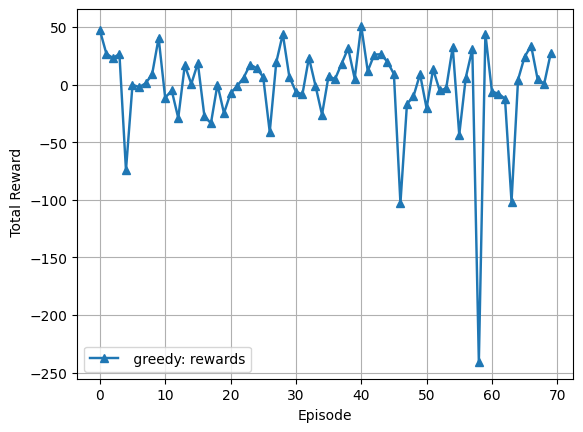

In [99]:
aver_greedy = []
step = (len(log_total_reward_greedy)+1)/num_episodes
for i in range(0, len(log_total_reward_greedy), int(step)):
  greedy_eps_i = log_total_reward_greedy[i:i+int(step)-1]
  aver_greedy.append(np.mean(greedy_eps_i))
  i += 1

plt.grid()
plt.plot(aver_greedy, "^-", label=' greedy: rewards', linewidth=1.75)
plt.xlabel("Episode")
plt.ylabel(" Total Reward")
plt.legend(loc = "best")
plt.show()

In [100]:
import os
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
save_path = now.strftime("%d_%m_%Y_%H_%M_%S")
model_path = "_Greedy_total_rw.csv"
path = save_path + model_path
print(path)
episode = num_episodes 
num = int(step)*episode
with open(f'{path}','w') as f: 
    write = csv.writer(f) 
    for i in range(num):
         write.writerow([log_total_reward_greedy[i], log_comp_reward_greedy[i], log_cost_reward_greedy[i], log_anten_reward_greedy[i], log_connect_reward_greedy[i]])


06_04_2023_16_46_22_Greedy_total_rw.csv
